# Compare Hessian, metric tensor and vanilla SGD

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import os

import pennylane as qml
from pennylane import expval, var

from matplotlib import pyplot as plt

from vqc_loss_landscapes.hess_vs_metrictensor import *

import numpy as np

from pennylane.utils import _flatten, unflatten
from pennylane.optimize import GradientDescentOptimizer

from tqdm.notebook import tqdm as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Draw circuit with Qiskit.Aer device

In [ ]:
width = 2  # must be odd
layers = 2

target = np.ones((2**width,))*(1/np.sqrt(2**width))
rho_target = np.outer(target ,np.conj(target).T)

init_params = np.random.uniform(low=0.0, high=2 * np.pi, size=width * layers *3)

model = Setup_For_Training(layers, width, rho_target, device="qiskit.aer")

theta = init_params.copy()

circuit = model.qcircuit

circuit(theta)
a = model.dev._circuit
a.draw()

┌────────────┐┌────────────┐ ┌────────────┐   ┌───────────┐ »
q_0: ─┤ RZ(5.3773) ├┤ RY(2.2459) ├─┤ RZ(2.0572) ├─■─┤ RZ(1.934) ├─»
     ┌┴────────────┤├────────────┤┌┴────────────┤ │ ├───────────┴┐»
q_1: ┤ RZ(0.24209) ├┤ RY(0.4382) ├┤ RZ(0.55355) ├─■─┤ RZ(4.2309) ├»
     └─────────────┘└────────────┘└─────────────┘   └────────────┘»
c_0: ═════════════════════════════════════════════════════════════»
                                                                  »
c_1: ═════════════════════════════════════════════════════════════»
                                                                  »
«     ┌────────────┐┌────────────┐   ┌──────────┐┌─┐   
«q_0: ┤ RY(2.0928) ├┤ RZ(1.0993) ├─■─┤1         ├┤M├───
«     ├────────────┤├────────────┤ │ │  unitary │└╥┘┌─┐
«q_1: ┤ RY(0.5574) ├┤ RZ(3.8018) ├─■─┤0         ├─╫─┤M├
«     └────────────┘└────────────┘   └──────────┘ ║ └╥┘
«c_0: ════════════════════════════════════════════╩══╬═
«                                                    ║ 
«c_1: ═══════════════════════════════════════════════╩═
«

normal SGD


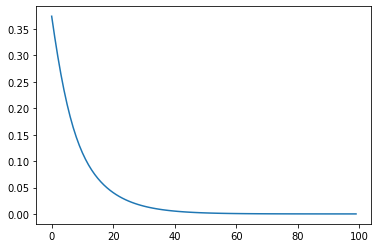

Metric Tensor


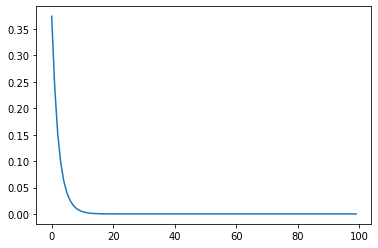

Hessian


KeyboardInterrupt: 

In [ ]:
shots = 8192
epochs = 100

width = 2
layers = 2

target = np.ones((2**width,))*(1/np.sqrt(2**width))
rho_target = np.outer(target ,np.conj(target).T)

model = Setup_For_Training(layers, width, rho_target, device="default.qubit")

theta = init_params.copy()

circuit = model.qcircuit

for new_params in range(50):
    init_params = np.random.uniform(low=0.0, high=2 * np.pi, size=width * layers*3)
    plot_lists = []
    lr_list = []
    for run in range(3):
        lr=0.1
        opt = qml.GradientDescentOptimizer(lr)
        epochs=100
        if run==0:
            print("normal SGD")
            get_hessian=False
            get_metr_tens=False
        if run==1:
            print("Metric Tensor")
            get_hessian=False
            get_metr_tens=True
        if run==2:
            print("Hessian")
            get_hessian=True
            get_metr_tens=False

        loss_list = []
        learning_rates = []
        metric_tensor_list = []
        params = init_params.copy()
        progress = tqdm(range(epochs), bar_format='{desc}')
        for it in progress:
            loss = model.cost_fidelity(params, circuit)
            loss_list.append(loss)
            if get_hessian==True:
                H = model.Hessian(params, circuit)
                Hev, Hv = np.linalg.eigh(H)
                lr = 1/Hev.max()
                opt = qml.GradientDescentOptimizer(lr)
                params = opt.step(lambda v: model.cost_fidelity(v, circuit), params)
            elif get_metr_tens == True:
                params, tensor = step(params, lr, 
                                      circuit.metric_tensor([params], diag_approx=False), 
                                      opt, model, circuit, lam=0.00000001)
                metric_tensor_list.append(tensor)
            else:
                params = opt.step(lambda v: model.cost_fidelity(v, circuit), params)
            
            progress.set_description_str('loss: {:3f}'.format(loss))
            learning_rates.append(lr)
        plot_lists.append(loss_list)
        lr_list.append(learning_rates)
        plt.plot(loss_list)
        plt.show()
    for plot in plot_lists:
        plt.plot(plot)
    plt.show()